In [1]:
# imports
import pandas as pd
import numpy as np
import findiff
from os import listdir
from sklearn.manifold import MDS
from scipy.stats import wasserstein_distance as wd
from matplotlib import pyplot as plt
import seaborn as sns         
from mvlearn.embed import MVMDS
from sklearn.cluster import KMeans
from sklearn import metrics

In [2]:
###reading data of a mouvement from the csm file
#name of columns
# tmp = ['Nose','LEI','LE','LEO','REI','RE','REO','LEAR','REAR','ML','MR','LSH','RSH','LELBOW','RELBOW','LW','RW','LP','RP','LI','RI','LTH','RTH','LH','RH','LK','RK','LA','RA','LHE','RHE','LF','RF']header2 = ['LFrontHead', 'RFrontHead', 'LBackHead', 'RBackHead', 'TopSpine', 'Sternum', 'Chest', 'LShoulder', 'LOuterElbow', 'LWristThumb', 'LWristPinky', 'LHand', 'RShoulder', 'ROuterElbow', 'RWristThumb', 'RWristPinky', 'RHand', 'MiddleBack', 'LowerBack', 'LFrontWaist', 'RFrontWaist', 'LBackWaist', 'RBackWaist', 'LOuterKnee', 'ROuterKnee', 'LAnkle', 'RAnkle', 'LHeel', 'RHeel', 'LOuterMeta', 'ROuterMeta', 'LToe', 'RToe']
tmp = ['Nose','LEI','LE','LEO','REI','RE','REO','LEAR','REAR','ML','MR','LSH','RSH','LELBOW','RELBOW','LW','RW','LP','RP','LI','RI','LTH','RTH','LH','RH','LK','RK','LA','RA','LHE','RHE','LF','RF']

header= []
for i in tmp:
    header.append(i+"_x")
    header.append(i+"_y")
    header.append(i+"_z")


distributions=[]#distribution de vitesse par mouvement (chaque element est une liste de distribution des differents capteurs)

#processing all the files in DataCSM folder
'''
 tmps vous aidera a parcourir tous les fichiers CSM dans le dossier DataCSM,
 pour lancer pour les fichiers test, mettez la prochaine ligne en commentaire
 et enlever le # de la ligne d'apres
'''
tmps = listdir("output") # current directory
#tmps = ["ale_lift_an_1_fin.csm","ali_lift_an_1_fin.csm","amc_lift_ha_1_fin.csm","emm_e_lift_ha_1_fin.csm"] #name of files used here for testing

for tmp in tmps:
    #read data
    try:
        data = pd.read_csv("output/"+tmp,sep=" ",header=None)
        data = data.drop(columns=data.columns[-1]) #delete useless NA filled last column
    except pd.errors.ParserError: #contains "DROPOUT" as values for some sensors at the end, separated with spaces and not tabs, which messes up the parsins 
        data = pd.read_csv("output/"+tmp,sep=" ",header=None,names=list(range(130))) #fix a number of columns so the parsing doesn't check size of result
    
    data.columns=header #set col names

    #grad of each column
    dt = 1/60 # distance between two frames is (1/60)s
    grad=findiff.Gradient(h=[dt])
    vitesses=[] #liste rad vitesse inst
    for col in range(len(data.columns)):
        d = np.array(data[data.columns[col]])
        v = grad(d)
        vitesses.append(v[0])
    
    #processing distribution for each column (result of hist are couples (distribution,bins), so we take only the first part of the hist)
    distribution = []
    for v in vitesses:
        distribution.append(np.histogram(v,bins=101,range=[0,500])[0])
    
    distributions.append(distribution)

In [3]:
#processing the wassenstein distances and making the distance matrix for MDS (! for the first captor !)
nb_mvt = len(tmps) #nombre de mouvements
nb_sensors = len(distributions[0])
Xs = []

for k in range(nb_sensors):
    w_dist=np.empty((nb_mvt,nb_mvt))
    for i in range(nb_mvt):
        w_dist[i][i]=0
        for j in range(i+1,nb_mvt):
            w_dist[i][j] = w_dist[j][i] = wd(distributions[i][k],distributions[j][k])
    Xs.append(w_dist)
        
print(len(Xs))


99


In [4]:
#using MVMDS
mds = MVMDS(dissimilarity='precomputed')
pts = mds.fit_transform(Xs)
mds.__dict__

{'components_': array([[-0.01221705, -0.0534707 ],
        [-0.04703893, -0.01817138],
        [ 0.0411188 , -0.04000218],
        ...,
        [-0.03385239,  0.04386121],
        [-0.02669758, -0.01191128],
        [ 0.0162915 , -0.02450752]]),
 'n_components': 2,
 'num_iter': 15,
 'dissimilarity': 'precomputed'}

In [21]:
pts.shape

(626, 15)

<h1> Visualisation

Legend


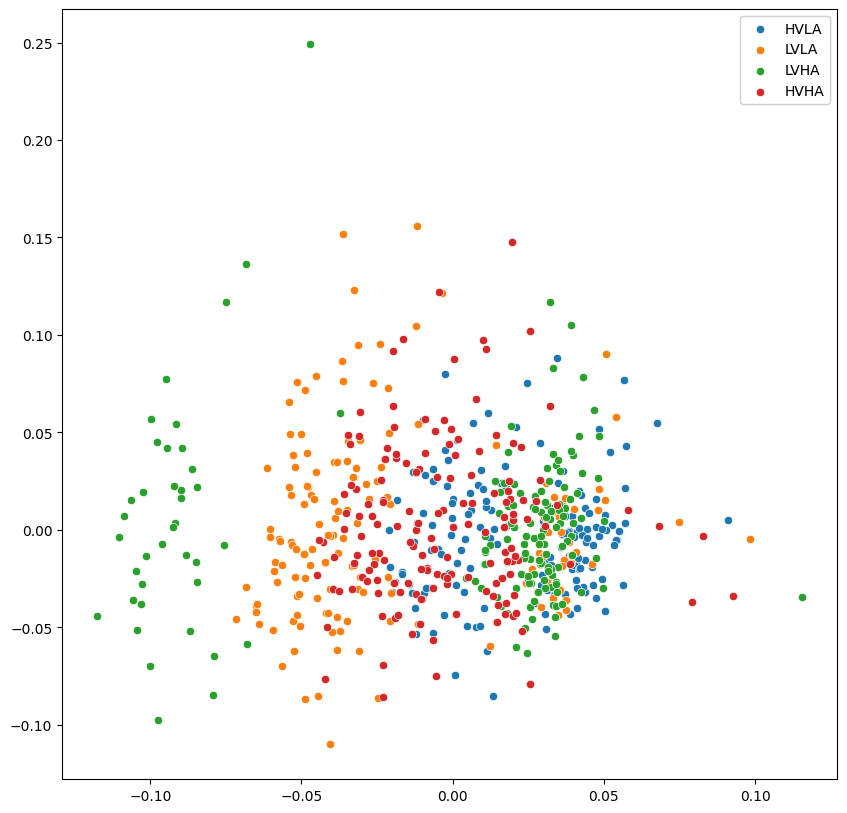

In [9]:
tmps = listdir("output") # current directory

#grp = { 'emotion' : [ [x1,x2] , [y1,y2] , color ] , ...}
grp = {}
for i in range(len(tmps)):
    tmp = tmps[i].split("_") # list of all names of files where are seperated by _
    #['ale', 'lift', 'an', '1', 'fin.csm']
    if tmp[-3]== '4' or tmp[-3]== '5' or tmp[-3]== '80' or tmp[-3]== '9':
        tmp[-2]='HVHA'
    elif tmp[-3]== '10' or tmp[-3]== '13' or tmp[-3]== '18' or tmp[-3]== '58':
        tmp[-2]='HVLA'
    elif tmp[-3]== '30' or tmp[-3]== '31' or tmp[-3]== '34' or tmp[-3]== '36':
        tmp[-2]= 'LVHA'
    else:
        tmp[-2] = 'LVLA'
    
    if tmp[-2] not in grp.keys():
         grp[tmp[-2]]=[[],[]]
    grp[tmp[-2]][0].append(pts[i][0])
    grp[tmp[-2]][1].append(pts[i][1])
fig = plt.figure(figsize=(10,10))
for i in range(len(grp.keys())):
    i = list(grp.keys())[i]
    ax = sns.scatterplot(x=grp[i][0], y=grp[i][1])
legend1 = ax.legend(grp.keys())
print(legend1)
ax.add_artist(legend1)

In [ ]:
#Prep to visualize shapes (exercices) and colors (emitons)

tmps = listdir("output/output333") # current directory
shapes = ["*","v","H","X","P","^"]

# Plot using different shapes
# for i, shape in enumerate(shapes):
#     plt.plot([i], [i], marker=shape, markersize=10)
emotions = []

#grp = { 'exercice' : [ [x1,x2] , [y1,y2] , [color1,color2] ] , ...}
grp = {}

for i in range(len(tmps)):
    tmp = tmps[i].split("_")
    if tmp[-3]== '4' or tmp[-3]== '5' or tmp[-3]== '80' or tmp[-3]== '9':
        tmp[-2]='HVHA'
    elif tmp[-3]== '10' or tmp[-3]== '13' or tmp[-3]== '18' or tmp[-3]== '58':
        tmp[-2]='HVLA'
    elif tmp[-3]== '30' or tmp[-3]== '31' or tmp[-3]== '34' or tmp[-3]== '36':
        tmp[-2]= 'LVHA'
    else:
        tmp[-2] = 'LVLA'
    # print(tmp)
    if tmp[-4] not in grp.keys():
        grp[tmp[-4]]=[ [],[],[] ]
    grp[tmp[-4]][0].append(pts[i][0])
    grp[tmp[-4]][1].append(pts[i][1])
    
    if tmp[-2] not in emotions:
        emotions.append(tmp[-2])
    grp[tmp[-4]][2].append(emotions.index(tmp[-2])*7)
    
fig = plt.figure(figsize=(10,10))
for i in range(len(grp.keys())):
    tmp=shapes[i]
    i = list(grp.keys())[i]
    ax = sns.scatterplot(x=grp[i][0], y=grp[i][1], c=grp[i][2], marker=tmp)
legend1 = ax.legend(grp.keys())
ax.add_artist(legend1)

<h1> Kmean and visualisation

In [5]:
kmeans = KMeans( n_clusters=4,random_state=0).fit(pts)
clusters = kmeans.labels_

c:\Users\DELL\anaconda3\envs\IMS\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'Scattering into 4 clusters')

<Figure size 1000x1000 with 0 Axes>

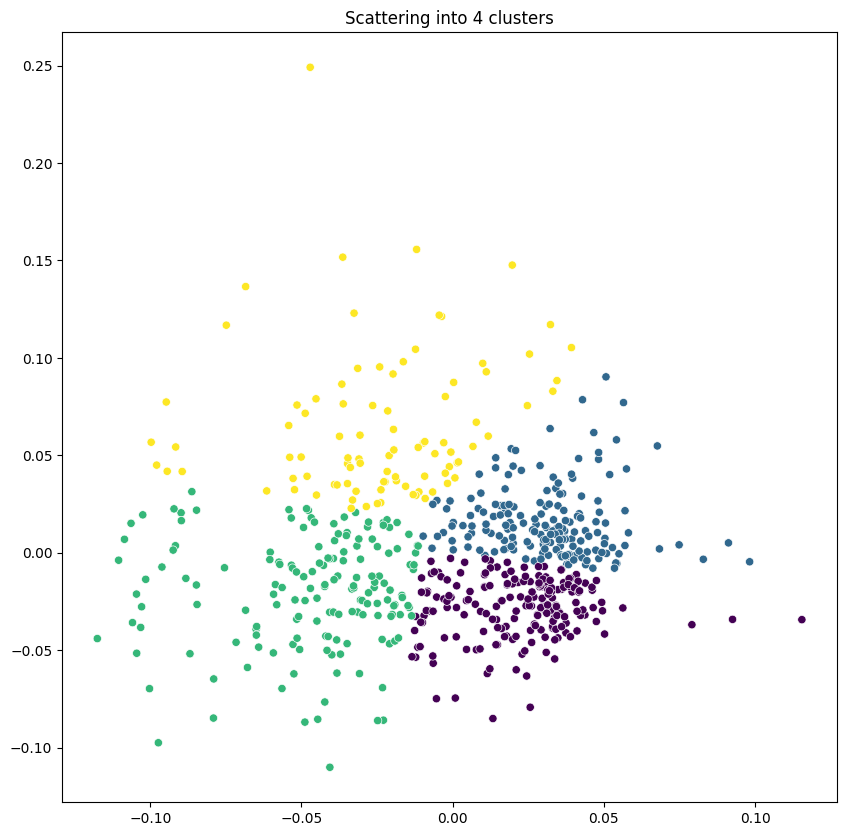

In [11]:
fig = plt.figure(figsize=(10,10))
X = []
Y = []
for i in range(len(pts)):
    X.append(pts[i][0])
    Y.append(pts[i][1])
fig = plt.figure(figsize=(10,10))
ax = sns.scatterplot(x=X,y=Y,c=kmeans.labels_)
plt.title("Scattering into 4 clusters")

<h1>Evaluation

In [7]:

    
tmps = listdir("output") # current directory

#grp = { 'emotion' : [ [x1,x2] , [y1,y2] , color ] , ...}
ems = []
for i in range(len(tmps)):
    tmp = tmps[i].split("_") # list of all names of files where are seperated by _
    #['ale', 'lift', 'an', '1', 'fin.csm']
    if tmp[-3]== '4' or tmp[-3]== '5' or tmp[-3]== '80' or tmp[-3]== '9':
        tmp[-2]='HVHA'
    elif tmp[-3]== '10' or tmp[-3]== '13' or tmp[-3]== '18' or tmp[-3]== '58':
        tmp[-2]='HVLA'
    elif tmp[-3]== '30' or tmp[-3]== '31' or tmp[-3]== '34' or tmp[-3]== '36':
        tmp[-2]= 'LVHA'
    else:
        tmp[-2] = 'LVLA'
    ems.append(tmp[-2])
em = np.unique(ems)

In [8]:

from itertools import permutations
comb_predd=[]
categories = em
label= list(kmeans.labels_)
labels = np.unique(label)
acc = []
kappa =[]
mcc = []
mappings = []
combinations = list(permutations(labels, len(labels)))

for combination in combinations:
    mapping = dict(zip(combination, categories))
    mappings.append(mapping)
    converted = [mapping[emo] for emo in label]
    comb_predd.append(converted)
    for i in range(len(comb_predd)):
        report_kmeans = metrics.classification_report(ems,comb_predd[i])
        accuracy =float(report_kmeans.split()[-14])
        kappa_kmean = metrics.cohen_kappa_score(ems,comb_predd[i])
        mcc_kmean = metrics.matthews_corrcoef(ems,comb_predd[i])
    mcc.append(mcc_kmean)
    acc.append(accuracy)
    kappa.append(kappa_kmean)
# print(acc)
best_acc = max(acc)
best_mcc = max(mcc)
best_kappa = max(kappa)
acc_idx= acc.index(best_acc)
mcc_idx= mcc.index(best_mcc)
kappa_idx= kappa.index(best_kappa)

print('best accuracy score:', best_acc,'with the cluster',mappings[acc_idx] )
print('best Matthews correlation coeficient:', best_mcc,'with the cluster',mappings[mcc_idx])
print('best kappa coeficient:', best_kappa,'with the cluster',mappings[kappa_idx])


best accuracy score: 0.38 with the cluster {3: 'HVHA', 1: 'HVLA', 0: 'LVHA', 2: 'LVLA'}
best Matthews correlation coeficient: 0.17115072269564596 with the cluster {3: 'HVHA', 1: 'HVLA', 0: 'LVHA', 2: 'LVLA'}
best kappa coeficient: 0.1693601616777468 with the cluster {3: 'HVHA', 1: 'HVLA', 0: 'LVHA', 2: 'LVLA'}


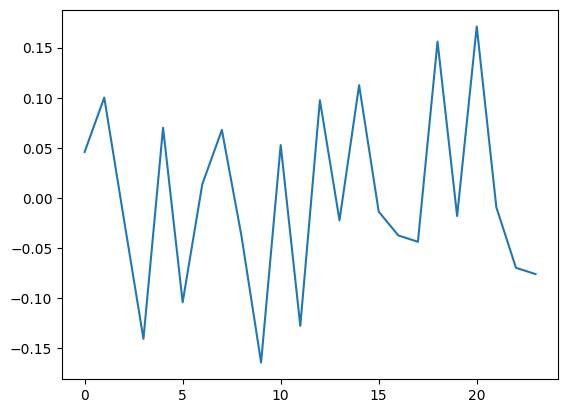

In [13]:
plt.plot(range(len(mcc)),mcc)

In [17]:
for i in range(len(ems)):
    if ems[i]=='HVLA':
        ems[i]= 0
    elif ems[i]=='LVLA':
        ems[i]= 1
    elif ems[i]=='LVHA':
        ems[i]= 2
    else :
        ems[i]=3

In [ ]:
prediction=list(kmeans.labels_) # to make for all clusters 
report_kmeans= metrics.classification_report(ems,prediction)
print(report_kmeans)

In [15]:
lines = report_kmeans.split('\n')
lines = [line.strip().split() for line in lines if line.strip()] 
# Split each line and remove empty lines
c_lines = ['  ', 'precision','recall', 'f1-score', 'support']
df_kmeans= pd.DataFrame(lines[1:6], columns=c_lines)
new_names_kmeans = {'precision': 'precision_kmeans', 'recall': 'recall_kmeans', 'f1-score': 'f1-score_kmeans','support': 'support_kmeans'}
df_kmeans = df_kmeans.rename(columns=new_names_kmeans)

visualisation of detailed rapport about the atribution of emotion-to-cluster that gives the best accuracy (the value of comb_emo to write manually) 

<h3> trying other clustering methods

<h4> clustering methods

In [9]:
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=4)
clusters_GM = model.fit_predict(pts)


In [10]:
from itertools import permutations
comb_predd=[]
categories = em
label= list(clusters_GM)
labels = np.unique(label)
acc = []
kappa =[]
mcc_gm= []
mappings = []
combinations = list(permutations(labels, len(labels)))

for combination in combinations:
    mapping = dict(zip(combination, categories))
    mappings.append(mapping)
    converted = [mapping[emo] for emo in label]
    comb_predd.append(converted)
    for i in range(len(comb_predd)):
        report = metrics.classification_report(ems,comb_predd[i])
        accuracy =float(report.split()[-14])
        kappa_= metrics.cohen_kappa_score(ems,comb_predd[i])
        mcc_= metrics.matthews_corrcoef(ems,comb_predd[i])
    mcc_gm.append(mcc_)
    acc.append(accuracy)
    kappa.append(kappa_)
# print(acc)
best_acc = max(acc)
best_mcc = max(mcc_gm)
best_kappa = max(kappa)
acc_idx= acc.index(best_acc)
mcc_idx= mcc_gm.index(best_mcc)
kappa_idx= kappa.index(best_kappa)

print('best accuracy score:', best_acc,'with the cluster',mappings[acc_idx] )
print('best Matthews correlation coeficient:', best_mcc,'with the cluster',mappings[mcc_idx])
print('best kappa coeficient:', best_kappa,'with the cluster',mappings[kappa_idx])


best accuracy score: 0.35 with the cluster {0: 'HVHA', 2: 'HVLA', 1: 'LVHA', 3: 'LVLA'}
best Matthews correlation coeficient: 0.14118242911234322 with the cluster {0: 'HVHA', 2: 'HVLA', 1: 'LVHA', 3: 'LVLA'}
best kappa coeficient: 0.13518258904874025 with the cluster {0: 'HVHA', 2: 'HVLA', 1: 'LVHA', 3: 'LVLA'}


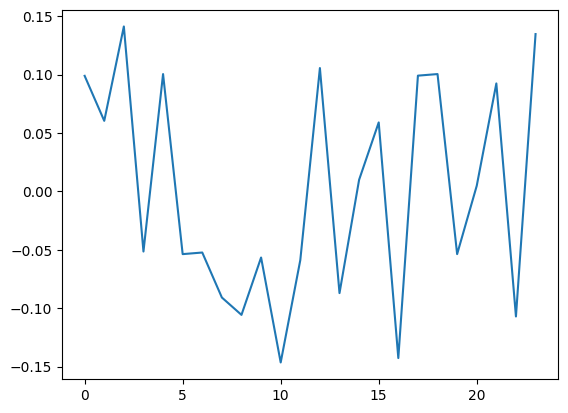

In [14]:
plt.plot(range(len(mcc_gm)),mcc_gm)

In [25]:
prediction_GM=list(clusters_GM)
report_GM = metrics.classification_report(ems,prediction_GM)
print(report_GM)

              precision    recall  f1-score   support

           0       0.07      0.08      0.07       157
           1       0.10      0.19      0.13       155
           2       0.31      0.24      0.27       157
           3       0.31      0.07      0.11       157

    accuracy                           0.14       626
   macro avg       0.20      0.14      0.15       626
weighted avg       0.20      0.14      0.15       626



In [18]:
lines = report_GM.split('\n')
lines = [line.strip().split() for line in lines if line.strip()] 
# Split each line and remove empty lines
c_lines = ['  ', 'precision','recall', 'f1-score', 'support']
df_gm= pd.DataFrame(lines[1:6], columns=c_lines)
new_names_gm = {'precision': 'precision_gm', 'recall': 'recall_gm', 'f1-score': 'f1-score_gm','support': 'support_gm'}
df_gm = df_gm.rename(columns=new_names_gm)

In [11]:
from sklearn.cluster import Birch
model = Birch(threshold=0.01, n_clusters=4)
clusters_B = model.fit_predict(pts)

In [12]:
from itertools import permutations
comb_predd=[]
categories = em
label= list(clusters_B)
labels = np.unique(label)
acc = []
kappa =[]
mcc_b= []
mappings = []
combinations = list(permutations(labels, len(labels)))

for combination in combinations:
    mapping = dict(zip(combination, categories))
    mappings.append(mapping)
    converted = [mapping[emo] for emo in label]
    comb_predd.append(converted)
    for i in range(len(comb_predd)):
        report = metrics.classification_report(ems,comb_predd[i])
        accuracy =float(report.split()[-14])
        kappa_= metrics.cohen_kappa_score(ems,comb_predd[i])
        mcc_= metrics.matthews_corrcoef(ems,comb_predd[i])
    mcc_b.append(mcc_)
    acc.append(accuracy)
    kappa.append(kappa_)
# print(acc)
best_acc = max(acc)
best_mcc = max(mcc_b)
best_kappa = max(kappa)
acc_idx= acc.index(best_acc)
mcc_idx= mcc_b.index(best_mcc)
kappa_idx= kappa.index(best_kappa)

print('best accuracy score:', best_acc,'with the cluster',mappings[acc_idx] )
print('best Matthews correlation coeficient:', best_mcc,'with the cluster',mappings[mcc_idx])
print('best kappa coeficient:', best_kappa,'with the cluster',mappings[kappa_idx])


best accuracy score: 0.37 with the cluster {1: 'HVHA', 2: 'HVLA', 3: 'LVHA', 0: 'LVLA'}
best Matthews correlation coeficient: 0.1706442109003613 with the cluster {1: 'HVHA', 2: 'HVLA', 3: 'LVHA', 0: 'LVLA'}
best kappa coeficient: 0.15441096412433986 with the cluster {1: 'HVHA', 2: 'HVLA', 3: 'LVHA', 0: 'LVLA'}


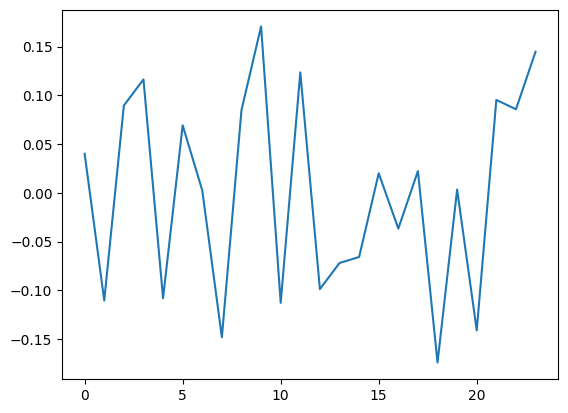

In [15]:
plt.plot(range(len(mcc_b)),mcc_b)

In [27]:
prediction_B=list(clusters_B)
report_B = metrics.classification_report(ems,prediction_B)
print(report_B)

              precision    recall  f1-score   support

           0       0.25      0.72      0.37       157
           1       0.17      0.05      0.07       155
           2       0.20      0.17      0.18       157
           3       0.50      0.01      0.01       157

    accuracy                           0.23       626
   macro avg       0.28      0.23      0.16       626
weighted avg       0.28      0.23      0.16       626



In [21]:
lines = report_B.split('\n')
lines = [line.strip().split() for line in lines if line.strip()] 
# Split each line and remove empty lines
c_lines = ['  ', 'precision','recall', 'f1-score', 'support']
df_b= pd.DataFrame(lines[1:6], columns=c_lines)
new_names_b = {'precision': 'precision_b', 'recall': 'recall_b', 'f1-score': 'f1-score_b','support': 'support_b'}
df_b = df_b.rename(columns=new_names_b)

In [16]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=4)
clusters_SC = model.fit_predict(pts)

In [17]:
from itertools import permutations
comb_predd=[]
categories = em
label= list(clusters_SC)
labels = np.unique(label)
acc = []
kappa =[]
mcc_sc= []
mappings = []
combinations = list(permutations(labels, len(labels)))

for combination in combinations:
    mapping = dict(zip(combination, categories))
    mappings.append(mapping)
    converted = [mapping[emo] for emo in label]
    comb_predd.append(converted)
    for i in range(len(comb_predd)):
        report = metrics.classification_report(ems,comb_predd[i])
        accuracy =float(report.split()[-14])
        kappa_= metrics.cohen_kappa_score(ems,comb_predd[i])
        mcc_= metrics.matthews_corrcoef(ems,comb_predd[i])
    mcc_sc.append(mcc_)
    acc.append(accuracy)
    kappa.append(kappa_)
# print(acc)
best_acc = max(acc)
best_mcc = max(mcc_sc)
best_kappa = max(kappa)
acc_idx= acc.index(best_acc)
mcc_idx= mcc_sc.index(best_mcc)
kappa_idx= kappa.index(best_kappa)

print('best accuracy score:', best_acc,'with the cluster',mappings[acc_idx] )
print('best Matthews correlation coeficient:', best_mcc,'with the cluster',mappings[mcc_idx])
print('best kappa coeficient:', best_kappa,'with the cluster',mappings[kappa_idx])


best accuracy score: 0.37 with the cluster {1: 'HVHA', 0: 'HVLA', 3: 'LVHA', 2: 'LVLA'}
best Matthews correlation coeficient: 0.16811206165125755 with the cluster {1: 'HVHA', 0: 'HVLA', 3: 'LVHA', 2: 'LVLA'}
best kappa coeficient: 0.16496978276256336 with the cluster {1: 'HVHA', 0: 'HVLA', 3: 'LVHA', 2: 'LVLA'}


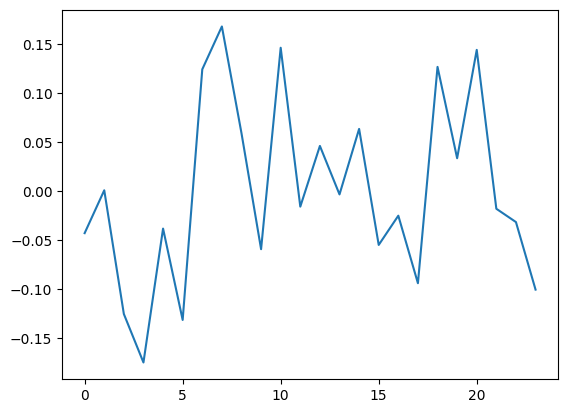

In [18]:
plt.plot(range(len(mcc_sc)),mcc_sc)

In [29]:
prediction_SC=list(clusters_SC)
report_SC = metrics.classification_report(ems,prediction_SC)
report_SC

'              precision    recall  f1-score   support\n\n           0       0.19      0.18      0.19       157\n           1       0.14      0.21      0.17       155\n           2       0.22      0.18      0.20       157\n           3       0.31      0.23      0.26       157\n\n    accuracy                           0.20       626\n   macro avg       0.22      0.20      0.20       626\nweighted avg       0.22      0.20      0.20       626\n'

<h4> visualisation of the clusters

Text(0.5, 1.0, 'Scattering into 4 clusters')

<Figure size 1000x1000 with 0 Axes>

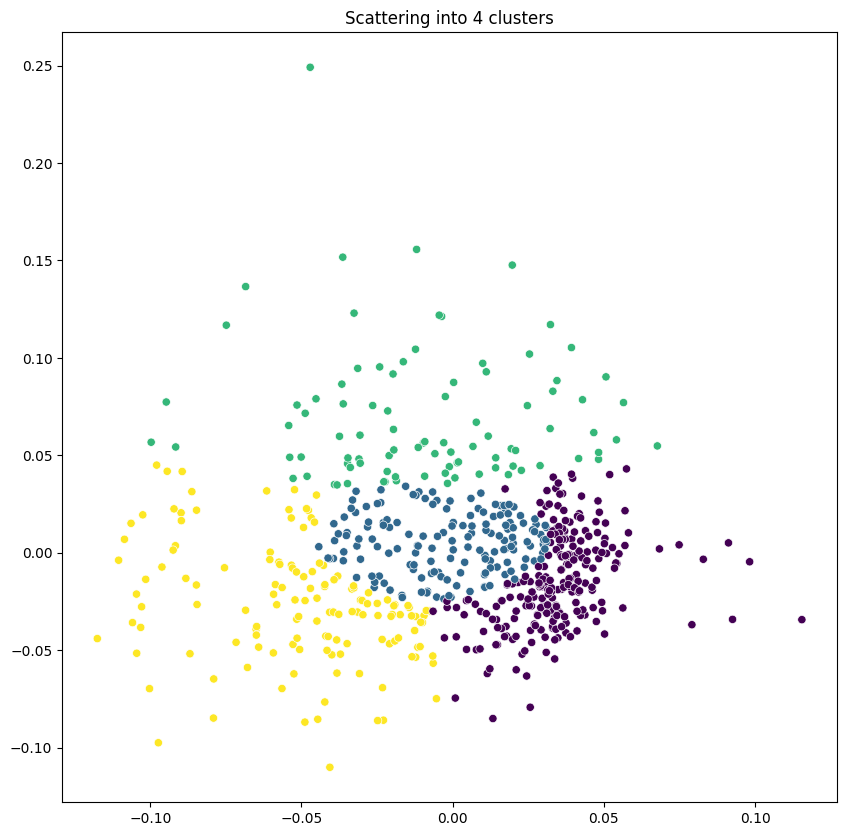

In [67]:
fig = plt.figure(figsize=(10,10))
X = []
Y = []
for i in range(len(pts)):
    X.append(pts[i][0])
    Y.append(pts[i][1])
fig = plt.figure(figsize=(10,10))
ax = sns.scatterplot(x=X,y=Y,c=clusters)
plt.title("Scattering into 4 clusters")